## 용어
- 예측 구간(prediction interval):개별 예측값 주위의 불확실한 구간
- 외삽법(extrapolation): 모델링에 사용된 데이터 범위를 벗어난 부분까지 모델을 확장하는것

## 신뢰구간(95%)
- 회귀계수와 예측을 둘러싼 불확실성 구간을 의미하는 신뢰구간<br><br>

<절차>
1. 각 행(결과변수를 포함)을 하나의 티켓으로 생각하고 개수가 모두 n개인 티켓을 박스에 넣었다고 가정한다.
2. 무작위로 티켓을 뽑아 값을 기록하고 다시 박스에 넣는다.
3. 2번 과정을 n 반복하여, 부트스트랩 재표본을 하나 만든다.
4. 이 부트스트랩 표본을 가지고 회귀모형을 구한 후, 추정된 계수들을 기록한다.
5. 2~4번 과정을 1000번 반복한다.
6. 얻은 1000개의 부트스트랩 값의 각각의 계수에 대하여 2.5번째 백분위수와 97.5번째 백분위수를 찾는다.

## 예측구간
- 예측값의 구간<br><br>

<절차>
1. 데이터로부터 부트스트랩 표본을 뽑는다.
2. 회귀모형을 찾고 새로운 값을 예측한다.
3. 원래의 회귀 적합도에서 임의로 하나의 잔차를 취하여 예측값에 더하고 그 결과를 기록한다.
4. 1~3단계를 1000번 반복
5. 결과의 2.5번째 백분위수와 97.5번째 백분위수를 찾는다.

In [1]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random

# 한글 폰트 설정
plt.rc("font", family='Malgun Gothic')

# - 깨짐 설정
plt.rcParams['axes.unicode_minus'] = False

In [2]:
house = pd.read_csv('../../data/house_sales.csv', sep='\t')

### 원래 회귀모형

In [3]:
feature = 'SqFtTotLiving'
label = 'AdjSalePrice'

In [4]:
orign_model = LinearRegression()
orign_model.fit(house[[feature]], house[label])

print(f"기울기: {orign_model.coef_}")
print(f"절편: {orign_model.intercept_}")

기울기: [293.20271358]
절편: -44676.967263193685


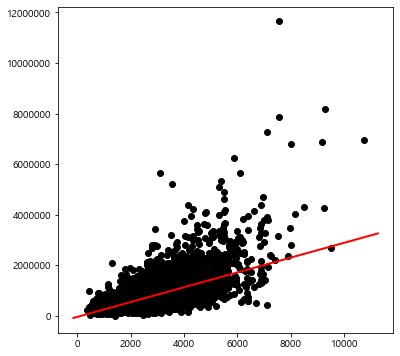

In [5]:
# 회귀선
def abline(slope, intercept, ax):
    xvals = ax.get_xlim()
    return xvals, slope*xvals + intercept

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(house[feature], house[label], color='black')
ax.plot(abline(orign_model.coef_, orign_model.intercept_, ax)[0], abline(orign_model.coef_, orign_model.intercept_, ax)[1],
        color='red', linewidth=2)
ax.ticklabel_format(axis='both', style='plain')

plt.show()

In [6]:
# 원래의 회귀 적합도에서의 잔차
residual = house[label] - orign_model.predict(house[[feature]])
residual

1       -358204.545333
2         17223.953342
3        202484.377285
4       -451506.716198
5       -162566.700097
             ...      
27057     54539.951162
27058    246956.159158
27061    -48305.936269
27062     -7473.682504
27063    288535.823534
Name: AdjSalePrice, Length: 22687, dtype: float64

### 예측구간 구하기

In [7]:
# 부트스트랩
pr_res = []
indcies = []
for _ in range(1000): # 부트스트랩을 1000번 반복
    sample = resample(house[[feature, label]]).drop_duplicates()
    bt_model = LinearRegression()
    bt_model.fit(sample[[feature]], sample[label])
    bt_prediction = pd.Series(bt_model.predict(sample[[feature]]), index=sample.index)
    random_bt_prediction_index = bt_prediction.sample(n=1).index
    pr_re = bt_prediction[random_bt_prediction_index] + residual[random_bt_prediction_index]  # 원래의 회귀 적합도에서 임의의 잔차값을 취하여 예측값에 더함
    indcies.append(random_bt_prediction_index[0])
    pr_res.append(pr_re.values[0])

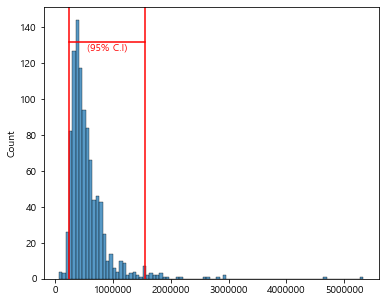

In [11]:
pr_res = pd.Series(pr_res, index=indcies)
confidence_interval = pr_res.quantile([0.025, 0.975]).values

fig,ax = plt.subplots(figsize=(6, 5))
sns.histplot(pr_res, ax=ax)
ax.ticklabel_format(axis='both', style='plain')
ax.axvline(x=confidence_interval[0], color='red')
ax.axvline(x=confidence_interval[1], color='red')
ax.plot([confidence_interval[0], confidence_interval[1]], [132, 132], color='red')
ax.text((confidence_interval[0] + confidence_interval[1])/2, 131, s='(95% C.I)', va='top', ha='center', color='red')

plt.show()